In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, ttest_rel, pearsonr
from PlotLikertOverConditions import *

## Helper Functions

In [85]:
def birthday_to_age(birthdays_data_frame):
    year_to_subtract = (birthdays_data_frame['reference'].month, birthdays_data_frame['reference'].day) < (birthdays_data_frame['born'].month, birthdays_data_frame['born'].day)
    years = birthdays_data_frame['reference'].year - birthdays_data_frame['born'].year
    
    return  years - (year_to_subtract)

In [86]:
sus_questions = ["Ich denke, dass ich das System gerne häufig benutzen würde.","Ich fand das System unnötig komplex.","Ich fand das System einfach zu benutzen.","Ich glaube, ich würde die Hilfe einer technisch versierten Person benötigen, um das System benutzen zu können.",
"Ich fand, die verschiedenen Funktionen in diesem System waren gut integriert.","Ich denke, das System enthielt zu viele Inkonsistenzen.", "Ich kann mir vorstellen, dass die meisten Menschen den Umgang mit diesem System sehr schnell lernen.","Ich fand das System sehr umständlich zu nutzen.", "Ich fühlte mich bei der Benutzung des Systems sehr sicher.","Ich musste eine Menge lernen, bevor ich anfangen konnte das System zu verwenden."]

def calculate_sus_score(sus_data_frame_row):
    total_score = 0
    for i, question in enumerate(sus_questions):
        answer_for_question = sus_data_frame_row[question]
        score_for_question = 0
        if("Stimme eher nicht zu" in answer_for_question):
            score_for_question = 1
        elif("weder noch" in answer_for_question):
            score_for_question = 2
        elif("Stimme etwas zu" in answer_for_question):
            score_for_question = 3
        elif("Stimme voll zu" in answer_for_question):
            score_for_question = 4
        is_negative_question = i % 2 != 0
        if(is_negative_question):
            score_for_question = 4 - score_for_question
        total_score += score_for_question
        
    return total_score * 2.5

In [87]:
ipq_questions = []

spatial_presence_questions = ['Ich hatte das Gefühl, daß die virtuelle Umgebung hinter mir weitergeht.', 'Ich hatte das Gefühl, nur Bilder zu sehen.', 'Ich hatte das Gefühl, in dem virtuellen Raum zu handeln statt etwas von außen zu bedienen.','Ich fühlte mich im virtuellen Raum anwesend.']
ipq_questions += spatial_presence_questions
likert_categories_type = pd.CategoricalDtype(categories=["trifft gar nicht zu", "trifft eher nicht zu", "teils-teils","trifft eher zu","trifft völlig zu"], ordered=True)
present_scale = pd.CategoricalDtype(categories=["hatte nicht das Gefühl", "hatte eher nicht das Gefühl", "teils-teils","hatte eher das Gefühl","hatte das Gefühl"], ordered=True)
present_question = "Ich hatte nicht das Gefühl, in dem virtuellen Raum zu sein."
ipq_questions.append(present_question)
encoded_spatial_presence_columns =['SP1','SP2','SP4','SP5']

spatial_presence_columns =['SP1','SP2','SP3','SP4','SP5']


general_presence_questions = 'In der computererzeugten Welt hatte ich den Eindruck, dort gewesen zu sein...'
ipq_questions.append(general_presence_questions)
general_presence_encoded = 'G1'
general_presence_scale = pd.CategoricalDtype(categories=['überhaupt nicht','eher nicht', 'weder noch', 'etwas', 'sehr stark'])

involvement_question_awareness = 'Wie bewußt war Ihnen die reale Welt, während Sie sich durch die virtuelle Welt bewegten (z.B. Geräusche, Raumtemperatur, andere Personen etc.)?' 
ipq_questions.append(involvement_question_awareness)
awareness_scale = pd.CategoricalDtype(categories=['extrem bewußt', 'etwas bewußt', 'mittelmäßig', 'etwas unbewußt', 'unbewußt'])
involvement_questions = ['Meine reale Umgebung war mir nicht mehr bewußt.','Ich achtete noch auf die reale Umgebung.', 'Meine Aufmerksamkeit war von der virtuellen Welt völlig in Bann gezogen.']
ipq_questions += involvement_questions
encoded_involvement_columns =['INV2','INV3','INV4']
involvement_columns =['INV1','INV2','INV3','INV4']

realism_question = 'Wie real erschien Ihnen die virtuelle Umgebung?'
ipq_questions.append(realism_question)
realism_scale = pd.CategoricalDtype(categories=['vollkommen real','real','weder noch','nicht real','gar nicht real'])
realism_similarity_question = 'Wie sehr glich Ihr Erleben der virtuellen Umgebung dem Erleben einer realen Umgebung?'
ipq_questions.append(realism_similarity_question)
similarity_scale = pd.CategoricalDtype(categories=['überhaupt nicht','nicht','mittelmäßig','etwas','vollständig'])
realism_world_question = 'Wie real erschien Ihnen die virtuelle Welt?'
ipq_questions.append(realism_world_question)
realism_world_scale = pd.CategoricalDtype(categories=['wie eine vorgestellte Welt','eher wie eine vorgestellte Welt','weder noch','fast nicht zu unterscheiden von der realen Welt','nicht zu unterscheiden von der realen Welt'])
realism_more_question = 'Die virtuelle Welt erschien mir wirklicher als die reale Welt.'
ipq_questions.append(realism_more_question)
experienced_realism_columns = ['REAL1', 'REAL2', 'REAL3', 'REAL4']



def encode_likert_ipq(ipq_results):
    for index, question in enumerate(spatial_presence_questions):
        encode(ipq_results, question, likert_categories_type, encoded_spatial_presence_columns[index])
    encode(ipq_results, present_question, present_scale, 'SP3')
   
    
    encode(ipq_results, general_presence_questions, general_presence_scale, general_presence_encoded)

    encode(ipq_results, involvement_question_awareness, awareness_scale, 'INV1')
    for index, question in enumerate(involvement_questions):
        encode(ipq_results, question, likert_categories_type, encoded_involvement_columns[index])
    encode(ipq_results, realism_question, realism_scale, 'REAL1')
    encode(ipq_results, realism_similarity_question, similarity_scale, 'REAL2')
    encode(ipq_results, realism_world_question, realism_world_scale, 'REAL3')
    encode(ipq_results, realism_more_question, likert_categories_type, 'REAL4')

def encode(ipq_results_data_frame, questions, category_type, encoded_questions):
    ipq_results_data_frame.loc[:,questions] = ipq_results_data_frame.loc[:,questions].astype(category_type)
    # subtract 2 to get scale -2, 1, 0, 1, 2 instead from 0 to 5
    ipq_results_data_frame.loc[:,encoded_questions] = (ipq_results_data_frame.loc[:,questions].cat.codes - 2)
  

In [88]:


def calculate_medians_ipq(ipq_results):
    calculate_median_ipq(ipq_results,'spatial_presence_median', spatial_presence_columns)
    calculate_median_ipq(ipq_results, 'involvement_median', involvement_columns)
    calculate_median_ipq(ipq_results, 'experienced_realism_median', experienced_realism_columns)





def calculate_median_ipq(ipq_results_data_frame, median_name, columns):
    ipq_results_data_frame.loc[:,median_name] = ipq_results_data_frame.loc[:,columns].median(axis=1)


In [89]:
ipq_columns = [general_presence_encoded]
ipq_columns = ipq_columns + spatial_presence_columns
ipq_columns = ipq_columns + involvement_columns
ipq_columns = ipq_columns + experienced_realism_columns

def calculate_ipq_score(ipq_results_data_frame):
    calculate_score(ipq_results_data_frame, 'IPQ_score', ipq_columns)

def calculate_score(results_data_frame, score_name, columns):
    results_data_frame[score_name] = 0
    for column in columns:
        results_data_frame[score_name] = results_data_frame[score_name] + results_data_frame[column]
        
    

In [90]:
pq_questions = ["Ich konnte die Ereignisse gut kontrollieren.", "Ich habe die Interaktion mit der virtuellen Umgebung als natürlich empfunden.", "Die visuellen Aspekte haben mich stark eingezogen.", "Ich finde das Kontrollieren der Bewegung natürlich.", "Ich finde die Bewegungen von Objekten im virtuellen Raum waren überzeugend.", "Ich konnten die Umgebung mit meinen Augen leicht durchsuchen.","Ich empfand es natürlich sich durch die virtuelle Welt zu bewegen.", "Ich konnte die Objekte in der virtuellen Umgebung gut bewegen bzw. manipulieren.", "Ich war in dem virtuellen Erlebnis stark einbezogen.", "Ich finde es sehr einfach Objekte durch physische Interaktionen (z.B. Berührung) zu identifizieren.", "Das Audio hat mich stark eingezogen.", "Ich konnte verschiedene Geräusche gut unterscheiden.","Ich konnte Geräusche gut lokalisieren.","Ich konnte die Umgebung gut mit meiner Hand wahrnehmen.","Ich konnte Objekte aus nächster Nähe beobachten.","Ich konnte Objekte gut von verschiedenen Perspektiven anschauen.","Ich konnte gut vorhersagen was die Reaktionen auf meine Aktionen sind.", "Ich konnte mich sehr schnell an die virtuelle Umgebung gewöhnen.", "Zum Ende des Spiels hatte ich das Gefühl mit der virtuellen Umgebung kompetent interagieren zu können.", "Ich konnte mich gut auf die Aufgaben das Spiel zu lösen konzentrieren ohne stark auf die Mechanismen um die Aufgaben zu lösen achten zu müssen.","Meine Sinne waren Stark in das Spiel einbezogen.","Es gab Momente in denen ich vollständig im Spiel eintauchen konnte.","Ich konnte mich leicht an die Geräte involviert im Spiel gewöhnen.","Für mich waren die Informationen die meine verschiedenen Sinne wahrgenommen haben konsistent.","Die Verzögerung zwischen meinen Aktionen und erwarteten Ergebnis waren angemessen.","Die Qualität der optischen Anzeige hat mich daran gehindert im Spiel einzutauchen.","Die Geräte die ich benutzt habe, haben mich abgelenkt."]

seven_point_likert_scale = pd.CategoricalDtype(categories=['gar nicht','wenig','eher wenig','weiß nicht, unentschieden', 'ein bisschen', 'stark', 'sehr stark'])

pq_encoded = ["PQ_INV1_enc","PQ_INV3_enc","PQ_INV4_enc","PQ_INV5_enc","PQ_INV6_enc","PQ_INV8_enc","PQ_INV9_enc","PQ_INV10_enc","PQ_INV11_enc","PQ_INV12_enc", "PQ_SEN1_enc","PQ_SEN2_enc","PQ_SEN3_enc","PQ_SEN4_enc","PQ_SEN5_enc","PQ_SEN6_enc", "PQ_IMM1_enc","PQ_IMM2_enc","PQ_IMM3_enc","PQ_IMM4_enc","PQ_IMM5_enc","PQ_IMM6_enc","PQ_IMM7_enc","PQ_IMM8_enc", "PQ_INT1_enc","PQ_INT2_enc","PQ_INT3_enc"]

def encode_pq(pq_results):
    for index, question in enumerate(pq_questions):
        encode(pq_results, question, seven_point_likert_scale, pq_encoded[index])

In [91]:
from __future__ import division
import numpy as np
import random

def sample(data):
    sample = [random.choice(data) for _ in range(len(data))]
    return sample

def bootstrap_t_test(treatment, control, nboot = 1000, direction = "less"):
    ones = np.vstack((np.ones(len(treatment)),treatment))
    treatment = ones.conj().transpose()
    zeros = np.vstack((np.zeros(len(control)), control))
    control = zeros.conj().transpose()
    Z = np.vstack((treatment, control))
    tstat = np.mean(treatment[:,1])-np.mean(control[:,1])
    tboot = np.zeros(nboot)
    for i in range(nboot):
        sboot = sample(Z)
        sboot = pd.DataFrame(np.array(sboot), columns=['treat', 'vals'])
        tboot[i] = np.mean(sboot['vals'][sboot['treat'] == 1]) - np.mean(sboot['vals'][sboot['treat'] == 0]) - tstat
    if direction == "greater":
        pvalue = np.sum(tboot>=tstat-0)/nboot
    elif direction == "less":
        pvalue = np.sum(tboot<=tstat-0)/nboot
    else:
        print ('Enter a valid arg for direction')

    print(f'The p-value is {pvalue}')

## Load Data

In [92]:
path_to_demographic_data = "../study-results/Demografische Fragen.csv"
path_to_presence_data = "../study-results/Game Studie.csv"

demographic_data_frame = pd.read_csv(path_to_demographic_data)
presence_data_frame = pd.read_csv(path_to_presence_data)
haptic_presence_data_frame = presence_data_frame[presence_data_frame["Spieltyp auf den sich dieser Fragebogen bezieht."] == "Mit Haptik"]
visual_presence_data_frame = presence_data_frame[presence_data_frame["Spieltyp auf den sich dieser Fragebogen bezieht."] == "Ohne Haptik"]

#all_data_frame = demographic_data_frame.merge(haptic_presence_data_frame,left_on="Id2", right_on="Id des Teilnehmers")
#all_data_frame = all_data_frame.merge(visual_presence_data_frame,left_on="Id2", right_on="Id des Teilnehmers")
#len(all_data_frame)

## Data Transformation

In [93]:

demographic_data_frame['born'] = pd.to_datetime(demographic_data_frame['Wann wurden Sie geboren?'])
demographic_data_frame['reference'] = pd.to_datetime(demographic_data_frame['Completion time'])

demographic_data_frame['age']=(demographic_data_frame.apply(birthday_to_age, axis=1))


In [94]:
encode_likert_ipq(haptic_presence_data_frame)
encode_likert_ipq(visual_presence_data_frame)

In [95]:
calculate_medians_ipq(haptic_presence_data_frame)
calculate_medians_ipq(visual_presence_data_frame)

In [96]:
ipq_score_columns = ['G1', 'SP_score', 'INV_score', 'REAL_score']
calculate_score(haptic_presence_data_frame, 'SP_score', spatial_presence_columns)
calculate_score(visual_presence_data_frame, 'SP_score', spatial_presence_columns)

calculate_score(haptic_presence_data_frame, 'INV_score', involvement_columns)
calculate_score(visual_presence_data_frame, 'INV_score', involvement_columns)

calculate_score(haptic_presence_data_frame, 'REAL_score', experienced_realism_columns)
calculate_score(visual_presence_data_frame, 'REAL_score', experienced_realism_columns)

In [97]:
calculate_ipq_score(haptic_presence_data_frame)
calculate_ipq_score(visual_presence_data_frame)

In [98]:
haptic_presence_data_frame[ipq_questions]

,"Ich hatte das Gefühl, daß die virtuelle Umgebung hinter mir weitergeht.","Ich hatte das Gefühl, nur Bilder zu sehen.","Ich hatte das Gefühl, in dem virtuellen Raum zu handeln statt etwas von außen zu bedienen.",Ich fühlte mich im virtuellen Raum anwesend.,"Ich hatte nicht das Gefühl, in dem virtuellen Raum zu sein.","In der computererzeugten Welt hatte ich den Eindruck, dort gewesen zu sein...","Wie bewußt war Ihnen die reale Welt, während Sie sich durch die virtuelle Welt bewegten (z.B. Geräusche, Raumtemperatur, andere Personen etc.)?",Meine reale Umgebung war mir nicht mehr bewußt.,Ich achtete noch auf die reale Umgebung.,Meine Aufmerksamkeit war von der virtuellen Welt völlig in Bann gezogen.,Wie real erschien Ihnen die virtuelle Umgebung?,Wie sehr glich Ihr Erleben der virtuellen Umgebung dem Erleben einer realen Umgebung?,Wie real erschien Ihnen die virtuelle Welt?,Die virtuelle Welt erschien mir wirklicher als die reale Welt.
0,trifft eher nicht zu,trifft gar nicht zu,trifft völlig zu,trifft völlig zu,hatte das Gefühl,sehr stark,unbewußt,trifft völlig zu,trifft gar nicht zu,trifft gar nicht zu,real,nicht,wie eine vorgestellte Welt,trifft eher nicht zu
3,trifft eher nicht zu,trifft eher nicht zu,trifft völlig zu,trifft eher zu,teils-teils,etwas,etwas unbewußt,trifft gar nicht zu,trifft eher zu,trifft völlig zu,vollkommen real,etwas,fast nicht zu unterscheiden von der realen Welt,trifft gar nicht zu
4,trifft eher nicht zu,trifft eher nicht zu,trifft eher zu,trifft völlig zu,hatte eher das Gefühl,etwas,etwas unbewußt,trifft völlig zu,trifft gar nicht zu,trifft völlig zu,real,etwas,weder noch,trifft eher nicht zu
7,teils-teils,trifft eher nicht zu,trifft eher zu,trifft eher zu,hatte eher das Gefühl,etwas,etwas unbewußt,trifft eher zu,trifft eher nicht zu,trifft eher zu,real,etwas,eher wie eine vorgestellte Welt,trifft eher zu
8,trifft eher zu,trifft eher nicht zu,trifft völlig zu,trifft völlig zu,hatte das Gefühl,sehr stark,etwas unbewußt,trifft eher nicht zu,teils-teils,trifft eher zu,weder noch,etwas,weder noch,trifft eher nicht zu
11,teils-teils,trifft eher nicht zu,trifft eher zu,trifft eher zu,hatte eher nicht das Gefühl,sehr stark,etwas unbewußt,trifft eher zu,trifft gar nicht zu,trifft völlig zu,real,etwas,eher wie eine vorgestellte Welt,trifft eher nicht zu
12,trifft gar nicht zu,trifft gar nicht zu,trifft eher nicht zu,teils-teils,hatte eher nicht das Gefühl,etwas,etwas bewußt,trifft gar nicht zu,teils-teils,trifft eher zu,nicht real,nicht,eher wie eine vorgestellte Welt,trifft gar nicht zu
15,trifft eher nicht zu,trifft gar nicht zu,teils-teils,trifft eher nicht zu,hatte das Gefühl,sehr stark,unbewußt,trifft völlig zu,trifft völlig zu,trifft völlig zu,real,mittelmäßig,weder noch,teils-teils


In [99]:
subscale_ipq_questionnaire_results = haptic_presence_data_frame[ipq_score_columns]
subscale_ipq_questionnaire_results.insert(0,'condition' , 'haptic')
visual_subscale_ipq_columns = visual_presence_data_frame[ipq_score_columns]
visual_subscale_ipq_columns.insert(0,'condition' , 'visual')
subscale_ipq_questionnaire_results = subscale_ipq_questionnaire_results.append(visual_subscale_ipq_columns)
subscale_ipq_questionnaire_results

,condition,G1,SP_score,INV_score,REAL_score
0,haptic,2,3,0,-5
3,haptic,1,1,2,-2
4,haptic,1,2,3,-1
7,haptic,1,2,2,0
8,haptic,2,6,1,0
11,haptic,2,0,2,-2
12,haptic,1,-6,-2,-3
15,haptic,2,-2,8,-1
1,visual,2,3,4,-2
2,visual,1,-1,0,-3


In [100]:
condition_ipq_questionnaire_results = haptic_presence_data_frame[ipq_columns]
condition_ipq_questionnaire_results.insert(0,'condition' , 'haptic')
visual_ipq_columns = visual_presence_data_frame[ipq_columns]
visual_ipq_columns.insert(0,'condition' , 'visual')
condition_ipq_questionnaire_results = condition_ipq_questionnaire_results.append(visual_ipq_columns)

In [101]:
condition_ipq_questionnaire_results

,condition,G1,SP1,SP2,SP3,SP4,SP5,INV1,INV2,INV3,INV4,REAL1,REAL2,REAL3,REAL4
0,haptic,2,-1,-2,2,2,2,2,2,-2,-2,-1,-1,-2,-1
3,haptic,1,-1,-1,0,2,1,1,-2,1,2,-2,1,1,-2
4,haptic,1,-1,-1,1,1,2,1,2,-2,2,-1,1,0,-1
7,haptic,1,0,-1,1,1,1,1,1,-1,1,-1,1,-1,1
8,haptic,2,1,-1,2,2,2,1,-1,0,1,0,1,0,-1
11,haptic,2,0,-1,-1,1,1,1,1,-2,2,-1,1,-1,-1
12,haptic,1,-2,-2,-1,-1,0,-1,-2,0,1,1,-1,-1,-2
15,haptic,2,-1,-2,2,0,-1,2,2,2,2,-1,0,0,0
1,visual,2,-1,-2,2,2,2,2,2,-2,2,-1,-1,-1,1
2,visual,1,-1,-2,-1,1,2,-1,-1,1,1,-1,0,-1,-1


In [102]:
encode_pq(haptic_presence_data_frame)
encode_pq(visual_presence_data_frame)

In [103]:
calculate_score(haptic_presence_data_frame, 'PQ_score', pq_encoded)
calculate_score(visual_presence_data_frame, 'PQ_score', pq_encoded)

### remove outlier

In [104]:
print(haptic_presence_data_frame)
#haptic_presence_data_frame = haptic_presence_data_frame.drop(6,axis="index") 
#haptic_presence_data_frame = haptic_presence_data_frame.drop(2,axis="index") 


#visual_presence_data_frame = visual_presence_data_frame.drop(6,axis="index") 
#visual_presence_data_frame = visual_presence_data_frame.drop(2,axis="index") 

    ID       Start time  Completion time      Email  Name  Id des Teilnehmers  \
0    1   8/3/21 0:44:17   8/3/21 1:15:07  anonymous   NaN                   1   
3    4   8/3/21 6:36:59   8/3/21 6:46:36  anonymous   NaN                   2   
4    5   8/3/21 6:48:21   8/3/21 7:15:04  anonymous   NaN                   3   
7    8   8/3/21 9:23:19   8/3/21 9:34:09  anonymous   NaN                   4   
8    9  8/3/21 10:14:36  8/3/21 10:54:38  anonymous   NaN                   5   
11  12  8/3/21 11:33:02  8/3/21 11:43:42  anonymous   NaN                   6   
12  13   8/4/21 9:55:13  8/4/21 10:38:32  anonymous   NaN                   7   
15  16  8/4/21 22:47:48  8/4/21 23:03:42  anonymous   NaN                   8   

   Spieltyp auf den sich dieser Fragebogen bezieht.     Dauer  \
0                                        Mit Haptik   4:43.96   
3                                        Mit Haptik   1:04.34   
4                                        Mit Haptik   1:02.34   
7         

## Transform Data for ARTool

In [105]:

haptic_and_visual_data_frame = haptic_presence_data_frame.merge(visual_presence_data_frame, left_on="Id des Teilnehmers", right_on="Id des Teilnehmers")

haptic_and_visual_data_frame.loc[:,'haptic_treatment_order'] = haptic_and_visual_data_frame.apply(lambda row:  'hf' if (row['Completion time_x'] <= row['Completion time_y']) else 'vf', axis=1)

haptic_presence_data_frame = haptic_presence_data_frame.merge(haptic_and_visual_data_frame[['Id des Teilnehmers','haptic_treatment_order']], left_on="Id des Teilnehmers", right_on="Id des Teilnehmers")
visual_presence_data_frame = visual_presence_data_frame.merge(haptic_and_visual_data_frame[['Id des Teilnehmers','haptic_treatment_order']], left_on="Id des Teilnehmers", right_on="Id des Teilnehmers")

haptic_presence_data_frame.loc[:,'treatment'] = 'h'
visual_presence_data_frame.loc[:,'treatment'] = 'v'

spatial_presence_median_artool_data_frame = pd.concat([haptic_presence_data_frame, visual_presence_data_frame])[['Id des Teilnehmers', 'haptic_treatment_order','treatment', 'spatial_presence_median']]
spatial_presence_median_artool_data_frame.rename(columns={'Id des Teilnehmers':'id_participant'}, inplace=True)
spatial_presence_median_artool_data_frame.to_csv("../study-results/spatial_presence_medians.csv", index=False)


## Explore the Sample of the Study

In [106]:
print(demographic_data_frame['age'])
print("min age: %d"%(demographic_data_frame['age'].min()))
print("median age: %d"%demographic_data_frame['age'].median())
print("mean age: %d"%demographic_data_frame['age'].mean())
print("max age: %d"%(demographic_data_frame['age'].max()))

0    56
1    18
2    21
3    53
4    40
5    31
6    26
7    54
Name: age, dtype: int64
min age: 18
median age: 35
mean age: 37
max age: 56


Männlich    4
Weiblich    3
Divers      1
Name: Was ist Ihr Geschlecht?, dtype: int64


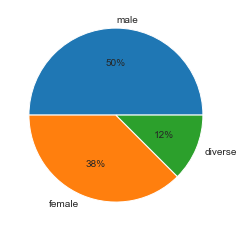

In [107]:
print(demographic_data_frame['Was ist Ihr Geschlecht?'].value_counts())
plt.pie(demographic_data_frame['Was ist Ihr Geschlecht?'].value_counts(), labels=['male', 'female', 'diverse'],autopct='%1.0f%%')
plt.show()

Nein    5
Ja      3
Name: Haben Sie zuvor ein mixed reality Gerät benutzt?, dtype: int64


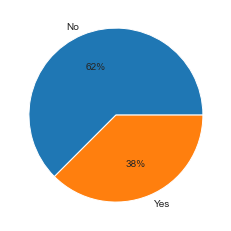

In [108]:
print(demographic_data_frame['Haben Sie zuvor ein mixed reality Gerät benutzt?'].value_counts())
plt.pie(demographic_data_frame['Haben Sie zuvor ein mixed reality Gerät benutzt?'].value_counts(), labels=['No', 'Yes'],autopct='%1.0f%%')
plt.show()

0     0
1     0
2     4
3     4
4     0
5     0
6    25
7     0
Name: Wie viele Stunden pro Woche spielen Sie Computerspiele?, dtype: int64


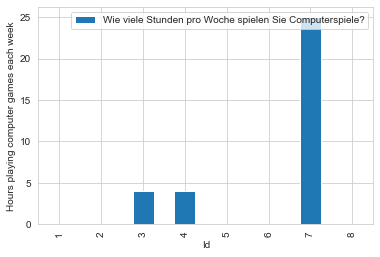

In [109]:
hours_playing_computer = 'Wie viele Stunden pro Woche spielen Sie Computerspiele?'
print(demographic_data_frame[hours_playing_computer])
fig, ax = plt.subplots()

reg_data = demographic_data_frame
reg_data.plot(x='Id2',
              y=hours_playing_computer,
kind='bar',
ax=ax)
ax.set_ylabel('Hours playing computer games each week')
ax.set_xlabel('Id')
plt.show()

## System Usability Scale

In [110]:
haptic_presence_data_frame['haptic_sus_score']=(haptic_presence_data_frame.apply(calculate_sus_score, axis=1))

visual_presence_data_frame['visual_sus_score']=(visual_presence_data_frame.apply(calculate_sus_score, axis=1))

print(haptic_presence_data_frame['haptic_sus_score'])
print("haptic min SUS: %d"%(haptic_presence_data_frame['haptic_sus_score'].min()))
print("haptic median SUS: %d"%haptic_presence_data_frame['haptic_sus_score'].median())
print("haptic max SUS: %d"%(haptic_presence_data_frame['haptic_sus_score'].max()))
print(visual_presence_data_frame['visual_sus_score'])
print("visual min SUS: %d"%(visual_presence_data_frame['visual_sus_score'].min()))
print("visual median SUS: %d"%visual_presence_data_frame['visual_sus_score'].median())
print("visual max SUS: %d"%(visual_presence_data_frame['visual_sus_score'].max()))

0    60.0
1    92.5
2    77.5
3    75.0
4    92.5
5    87.5
6    85.0
7    92.5
Name: haptic_sus_score, dtype: float64
haptic min SUS: 60
haptic median SUS: 86
haptic max SUS: 92
0    65.0
1    92.5
2    85.0
3    87.5
4    85.0
5    75.0
6    87.5
7    82.5
Name: visual_sus_score, dtype: float64
visual min SUS: 65
visual median SUS: 85
visual max SUS: 92


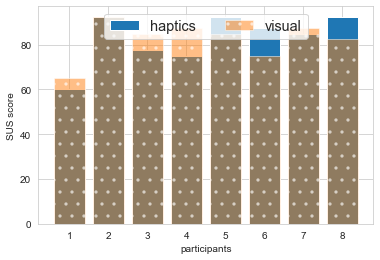

In [111]:

fig, ax = plt.subplots()

plt.bar(haptic_presence_data_frame['Id des Teilnehmers'], haptic_presence_data_frame['haptic_sus_score'])
plt.bar(visual_presence_data_frame['Id des Teilnehmers'],visual_presence_data_frame['visual_sus_score'], hatch= '.', alpha=0.5)

ax.legend(["haptics" , "visual"] , ncol = 2, loc = "upper center", fontsize="x-large")

plt.xlabel('participants')
plt.ylabel('SUS score')
plt.show()

## Analyze igroup presence questionnaire (IPQ)

In [112]:
import pingouin as pg

In [113]:
condition_ipq_questionnaire_results

,condition,G1,SP1,SP2,SP3,SP4,SP5,INV1,INV2,INV3,INV4,REAL1,REAL2,REAL3,REAL4
0,haptic,2,-1,-2,2,2,2,2,2,-2,-2,-1,-1,-2,-1
3,haptic,1,-1,-1,0,2,1,1,-2,1,2,-2,1,1,-2
4,haptic,1,-1,-1,1,1,2,1,2,-2,2,-1,1,0,-1
7,haptic,1,0,-1,1,1,1,1,1,-1,1,-1,1,-1,1
8,haptic,2,1,-1,2,2,2,1,-1,0,1,0,1,0,-1
11,haptic,2,0,-1,-1,1,1,1,1,-2,2,-1,1,-1,-1
12,haptic,1,-2,-2,-1,-1,0,-1,-2,0,1,1,-1,-1,-2
15,haptic,2,-1,-2,2,0,-1,2,2,2,2,-1,0,0,0
1,visual,2,-1,-2,2,2,2,2,2,-2,2,-1,-1,-1,1
2,visual,1,-1,-2,-1,1,2,-1,-1,1,1,-1,0,-1,-1


In [114]:
condition_ipq_questionnaire_results[ipq_columns]

,G1,SP1,SP2,SP3,SP4,SP5,INV1,INV2,INV3,INV4,REAL1,REAL2,REAL3,REAL4
0,2,-1,-2,2,2,2,2,2,-2,-2,-1,-1,-2,-1
3,1,-1,-1,0,2,1,1,-2,1,2,-2,1,1,-2
4,1,-1,-1,1,1,2,1,2,-2,2,-1,1,0,-1
7,1,0,-1,1,1,1,1,1,-1,1,-1,1,-1,1
8,2,1,-1,2,2,2,1,-1,0,1,0,1,0,-1
11,2,0,-1,-1,1,1,1,1,-2,2,-1,1,-1,-1
12,1,-2,-2,-1,-1,0,-1,-2,0,1,1,-1,-1,-2
15,2,-1,-2,2,0,-1,2,2,2,2,-1,0,0,0
1,2,-1,-2,2,2,2,2,2,-2,2,-1,-1,-1,1
2,1,-1,-2,-1,1,2,-1,-1,1,1,-1,0,-1,-1


In [115]:
print(f"haptic general presence score mean: {haptic_presence_data_frame['G1'].mean()}")
print(f"haptic general presence score median: {haptic_presence_data_frame['G1'].median()}")
print(f"haptic general presence score variance: {haptic_presence_data_frame['G1'].var()}")

haptic general presence score mean: 1.5
haptic general presence score median: 1.5
haptic general presence score variance: 0.2857142857142857


In [116]:
print(f"visual general presence score mean: {visual_presence_data_frame['G1'].mean()}")
print(f"visual general presence score median: {visual_presence_data_frame['G1'].median()}")
print(f"visual general presence score variance: {visual_presence_data_frame['G1'].var()}")

visual general presence score mean: 1.0
visual general presence score median: 1.0
visual general presence score variance: 0.8571428571428571


In [117]:

pg.cronbach_alpha(data=condition_ipq_questionnaire_results[ipq_columns])

(0.41707112970711285, array([-0.108,  0.761]))

In [118]:

pg.cronbach_alpha(data=haptic_presence_data_frame[spatial_presence_columns])

(0.7576815642458101, array([0.326, 0.945]))

In [119]:

pg.cronbach_alpha(data=visual_presence_data_frame[spatial_presence_columns])

(-1.1258278145695364, array([-4.914,  0.514]))

In [120]:
print(f"haptic spatial presence score mean: {haptic_presence_data_frame['SP_score'].mean()}")
print(f"haptic spatial presence score median: {haptic_presence_data_frame['SP_score'].median()}")
print(f"haptic spatial presence score variance: {haptic_presence_data_frame['SP_score'].var()}")

haptic spatial presence score mean: 0.75
haptic spatial presence score median: 1.5
haptic spatial presence score variance: 12.785714285714286


In [121]:
print(f"visual spatial presence score mean: {visual_presence_data_frame['SP_score'].mean()}")
print(f"visual spatial presence score median: {visual_presence_data_frame['SP_score'].median()}")
print(f"visual spatial presence score variance: {visual_presence_data_frame['SP_score'].var()}")

visual spatial presence score mean: 1.125
visual spatial presence score median: 1.5
visual spatial presence score variance: 2.6964285714285716


In [122]:

pg.cronbach_alpha(data=condition_ipq_questionnaire_results[involvement_columns])

(-0.03827751196172239, array([-1.223,  0.595]))

In [123]:
print(f"haptic involvement score mean: {haptic_presence_data_frame['INV_score'].mean()}")
print(f"haptic involvement score median: {haptic_presence_data_frame['INV_score'].median()}")
print(f"haptic involvement score variance: {haptic_presence_data_frame['INV_score'].var()}")

haptic involvement score mean: 2.0
haptic involvement score median: 2.0
haptic involvement score variance: 8.285714285714286


In [124]:
print(f"visual involvement score mean: {visual_presence_data_frame['INV_score'].mean()}")
print(f"visual involvement score median: {visual_presence_data_frame['INV_score'].median()}")
print(f"visual involvement score variance: {visual_presence_data_frame['INV_score'].var()}")

visual involvement score mean: 1.375
visual involvement score median: 2.0
visual involvement score variance: 4.553571428571429


In [125]:

pg.cronbach_alpha(data=condition_ipq_questionnaire_results[experienced_realism_columns])

(-0.5671812464265289, array([-2.356,  0.389]))

In [126]:
print(f"haptic experienced realism score mean: {haptic_presence_data_frame['REAL_score'].mean()}")
print(f"haptic experienced realism score median: {haptic_presence_data_frame['REAL_score'].median()}")
print(f"haptic experienced realism score variance: {haptic_presence_data_frame['REAL_score'].var()}")

haptic experienced realism score mean: -1.75
haptic experienced realism score median: -1.5
haptic experienced realism score variance: 2.7857142857142856


In [127]:
print(f"visual experienced realism score mean: {visual_presence_data_frame['REAL_score'].mean()}")
print(f"visual experienced realism score median: {visual_presence_data_frame['REAL_score'].median()}")
print(f"visual experienced realism score variance: {visual_presence_data_frame['REAL_score'].var()}")

visual experienced realism score mean: -2.625
visual experienced realism score median: -2.5
visual experienced realism score variance: 1.9821428571428572


In [128]:
subscale_ipq_questionnaire_results

,condition,G1,SP_score,INV_score,REAL_score
0,haptic,2,3,0,-5
3,haptic,1,1,2,-2
4,haptic,1,2,3,-1
7,haptic,1,2,2,0
8,haptic,2,6,1,0
11,haptic,2,0,2,-2
12,haptic,1,-6,-2,-3
15,haptic,2,-2,8,-1
1,visual,2,3,4,-2
2,visual,1,-1,0,-3


In [129]:
condition_ipq_questionnaire_results[ipq_columns]

,G1,SP1,SP2,SP3,SP4,SP5,INV1,INV2,INV3,INV4,REAL1,REAL2,REAL3,REAL4
0,2,-1,-2,2,2,2,2,2,-2,-2,-1,-1,-2,-1
3,1,-1,-1,0,2,1,1,-2,1,2,-2,1,1,-2
4,1,-1,-1,1,1,2,1,2,-2,2,-1,1,0,-1
7,1,0,-1,1,1,1,1,1,-1,1,-1,1,-1,1
8,2,1,-1,2,2,2,1,-1,0,1,0,1,0,-1
11,2,0,-1,-1,1,1,1,1,-2,2,-1,1,-1,-1
12,1,-2,-2,-1,-1,0,-1,-2,0,1,1,-1,-1,-2
15,2,-1,-2,2,0,-1,2,2,2,2,-1,0,0,0
1,2,-1,-2,2,2,2,2,2,-2,2,-1,-1,-1,1
2,1,-1,-2,-1,1,2,-1,-1,1,1,-1,0,-1,-1


In [130]:
#condition_ipq_questionnaire_results[ipq_columns] = condition_ipq_questionnaire_results[ipq_columns] + 3
#condition_ipq_questionnaire_results

In [131]:
# plotting expects likert from 1 and not from 0


customLikertRange={1:['not at all','very much'] ,
                   2:['fully disagree','fully agree'] ,
                   3:['fully disagree','fully agree'] ,
                   4:['did not feel','felt present'],
                   5:['fully disagree','fully agree'] ,
                   6:['fully disagree','fully agree'] ,
                   7:['extremely aware','not aware at all'] ,
                   8:['fully disagree','fully agree'],
                   9:['fully disagree','fully agree'] ,
                   10:['fully disagree','fully agree'] ,
                   11:['completely real','not real at all'] ,
                   12:['not consistent','very consistent'],
                   13:['about as real as an imagined world','indistinguishable from the real world'] ,
                   14:['fully disagree','fully agree'] }
#PlotLikertOverConditions(condition_ipq_questionnaire_results,5, customLikertRange)

### General Presence

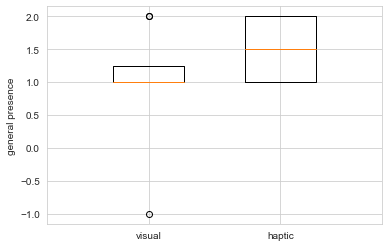

In [132]:

width = 0.35
# Creating plot
plt.boxplot(haptic_presence_data_frame.loc[:,general_presence_encoded], widths=width, labels=['haptic'])

plt.boxplot(visual_presence_data_frame.loc[:,general_presence_encoded], widths=width, positions=[width], labels=['visual'])

plt.ylabel('general presence')
# show plot
plt.show()  

In [133]:
wilcoxon(haptic_presence_data_frame[general_presence_encoded], visual_presence_data_frame[general_presence_encoded])

C:\Users\Malte\anaconda3\envs\game-study\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Malte\anaconda3\envs\game-study\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=0.0, pvalue=0.10247043485974937)

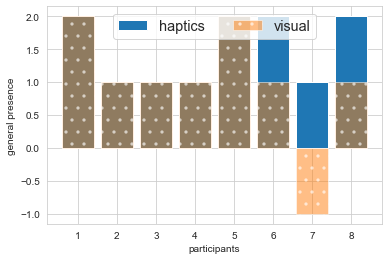

In [134]:
fig, ax = plt.subplots()

plt.bar(haptic_presence_data_frame['Id des Teilnehmers'], haptic_presence_data_frame[general_presence_encoded])
plt.bar(visual_presence_data_frame['Id des Teilnehmers'],visual_presence_data_frame[general_presence_encoded], hatch= '.', alpha=0.5)

ax.legend(["haptics" , "visual"] , ncol = 2, loc = "upper center", fontsize="x-large")

plt.xlabel('participants')
plt.ylabel('general presence')
plt.show()

### Spatial Presence

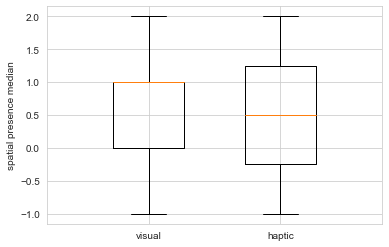

In [135]:
width = 0.35
# Creating plot
plt.boxplot(haptic_presence_data_frame.loc[:,'spatial_presence_median'], widths=width, labels=['haptic'])

plt.boxplot(visual_presence_data_frame.loc[:,'spatial_presence_median'], widths=width, positions=[width], labels=['visual'])

plt.ylabel('spatial presence median')
# show plot
plt.show()  

In [136]:
wilcoxon(haptic_presence_data_frame['spatial_presence_median'], visual_presence_data_frame['spatial_presence_median'])

C:\Users\Malte\anaconda3\envs\game-study\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Malte\anaconda3\envs\game-study\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=9.0, pvalue=0.7388826803635273)

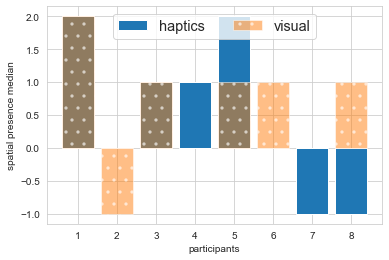

In [137]:
fig, ax = plt.subplots()

plt.bar(haptic_presence_data_frame['Id des Teilnehmers'], haptic_presence_data_frame['spatial_presence_median'])
plt.bar(visual_presence_data_frame['Id des Teilnehmers'],visual_presence_data_frame['spatial_presence_median'], hatch= '.', alpha=0.5)

ax.legend(["haptics" , "visual"] , ncol = 2, loc = "upper center", fontsize="x-large")

plt.xlabel('participants')
plt.ylabel('spatial presence median')
plt.show()

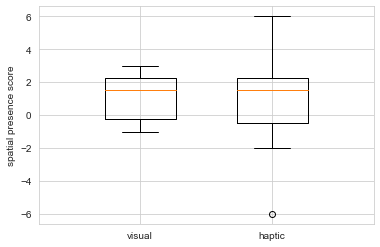

In [138]:
width = 0.35
# Creating plot
plt.boxplot(haptic_presence_data_frame.loc[:,'SP_score'], widths=width, labels=['haptic'])

plt.boxplot(visual_presence_data_frame.loc[:,'SP_score'], widths=width, positions=[width], labels=['visual'])

plt.ylabel('spatial presence score')
# show plot
plt.show()  

In [139]:
ttest_rel(haptic_presence_data_frame['SP_score'], visual_presence_data_frame['SP_score'])

Ttest_relResult(statistic=-0.2896345095710926, pvalue=0.7804868685868033)

In [140]:
pearsonr(haptic_presence_data_frame['SP_score'], visual_presence_data_frame['SP_score'])

(0.17639367512700221, 0.676058371541768)

### Involvement

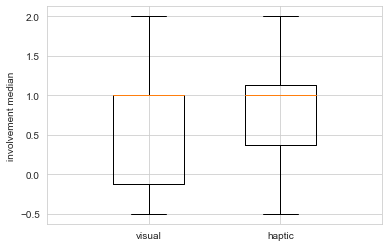

In [141]:
width = 0.35
# Creating plot
plt.boxplot(haptic_presence_data_frame.loc[:,'involvement_median'], widths=width, labels=['haptic'])

plt.boxplot(visual_presence_data_frame.loc[:,'involvement_median'], widths=width, positions=[width], labels=['visual'])

plt.ylabel('involvement median')
# show plot
plt.show()  

In [142]:
wilcoxon(haptic_presence_data_frame['involvement_median'], visual_presence_data_frame['involvement_median'])

C:\Users\Malte\anaconda3\envs\game-study\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Malte\anaconda3\envs\game-study\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=5.0, pvalue=0.4922069926558157)

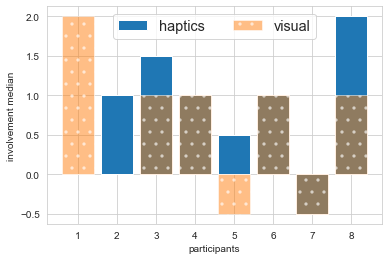

In [143]:
fig, ax = plt.subplots()

plt.bar(haptic_presence_data_frame['Id des Teilnehmers'], haptic_presence_data_frame['involvement_median'])
plt.bar(visual_presence_data_frame['Id des Teilnehmers'],visual_presence_data_frame['involvement_median'], hatch= '.', alpha=0.5)

ax.legend(["haptics" , "visual"] , ncol = 2, loc = "upper center", fontsize="x-large")

plt.xlabel('participants')
plt.ylabel('involvement median')
plt.show()

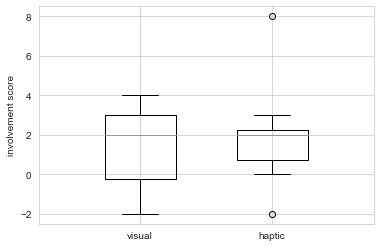

In [144]:
width = 0.35
# Creating plot
plt.boxplot(haptic_presence_data_frame.loc[:,'INV_score'], widths=width, labels=['haptic'])

plt.boxplot(visual_presence_data_frame.loc[:,'INV_score'], widths=width, positions=[width], labels=['visual'])

plt.ylabel('involvement score')
# show plot
plt.show()  

In [145]:
ttest_rel(haptic_presence_data_frame['INV_score'], visual_presence_data_frame['INV_score'])

Ttest_relResult(statistic=0.6759578833420166, pvalue=0.5207666929905368)

In [146]:
pearsonr(haptic_presence_data_frame['INV_score'], visual_presence_data_frame['INV_score'])

(0.4884051123325138, 0.21944878733209372)

### Experienced Realism

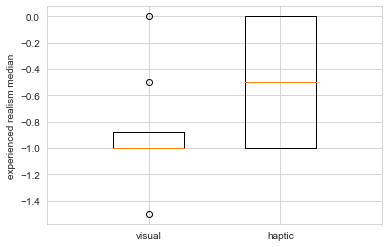

In [147]:
width = 0.35
# Creating plot
plt.boxplot(haptic_presence_data_frame.loc[:,'experienced_realism_median'], widths=width, labels=['haptic'])

plt.boxplot(visual_presence_data_frame.loc[:,'experienced_realism_median'], widths=width, positions=[width], labels=['visual'])

plt.ylabel('experienced realism median')
# show plot
plt.show()  

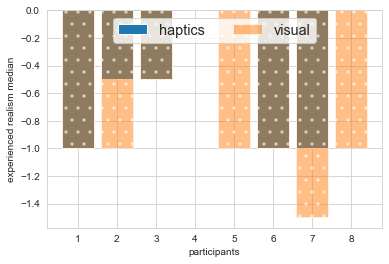

In [148]:
fig, ax = plt.subplots()

plt.bar(haptic_presence_data_frame['Id des Teilnehmers'], haptic_presence_data_frame['experienced_realism_median'])
plt.bar(visual_presence_data_frame['Id des Teilnehmers'],visual_presence_data_frame['experienced_realism_median'], hatch= '.', alpha=0.5)

ax.legend(["haptics" , "visual"] , ncol = 2, loc = "upper center", fontsize="x-large")

plt.xlabel('participants')
plt.ylabel('experienced realism median')
plt.show()

In [149]:
wilcoxon(haptic_presence_data_frame['experienced_realism_median'], visual_presence_data_frame['experienced_realism_median'])

C:\Users\Malte\anaconda3\envs\game-study\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Malte\anaconda3\envs\game-study\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=0.0, pvalue=0.0633177868300456)

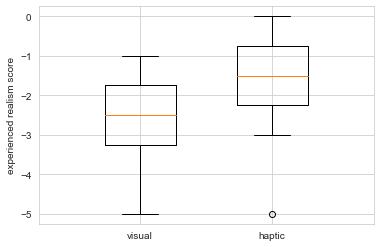

In [150]:
width = 0.35
# Creating plot
plt.boxplot(haptic_presence_data_frame.loc[:,'REAL_score'], widths=width, labels=['haptic'])

plt.boxplot(visual_presence_data_frame.loc[:,'REAL_score'], widths=width, positions=[width], labels=['visual'])

plt.ylabel('experienced realism score')
# show plot
plt.show()  

In [151]:
ttest_rel(haptic_presence_data_frame['REAL_score'], visual_presence_data_frame['REAL_score'])

Ttest_relResult(statistic=1.2630711924548441, pvalue=0.24700652745365284)

In [152]:
pearsonr(haptic_presence_data_frame['REAL_score'], visual_presence_data_frame['REAL_score'])

(0.19758299278793973, 0.6390607791028851)

## total IPQ score

In [153]:
print(f"haptic total IPQ score mean: {haptic_presence_data_frame['IPQ_score'].mean()}")
print(f"haptic total IPQ realism score median: {haptic_presence_data_frame['IPQ_score'].median()}")
print(f"haptic total IPQ realism score variance: {haptic_presence_data_frame['IPQ_score'].var()}")

haptic total IPQ score mean: 2.5
haptic total IPQ realism score median: 3.5
haptic total IPQ realism score variance: 34.0


In [154]:
print(f"visual total IPQ score mean: {visual_presence_data_frame['IPQ_score'].mean()}")
print(f"visual total IPQ realism score median: {visual_presence_data_frame['IPQ_score'].median()}")
print(f"visual total IPQ realism score variance: {visual_presence_data_frame['IPQ_score'].var()}")

visual total IPQ score mean: 0.875
visual total IPQ realism score median: 1.5
visual total IPQ realism score variance: 17.839285714285715


In [155]:
print(haptic_presence_data_frame['IPQ_score'])
print(visual_presence_data_frame['IPQ_score'])

0     0
1     2
2     5
3     5
4     9
5     2
6   -10
7     7
Name: IPQ_score, dtype: int64
0    7
1   -3
2    3
3    1
4    1
5    3
6   -7
7    2
Name: IPQ_score, dtype: int64


In [156]:
def show_mean_percentage_change(starting_value, final_value):
    starting_value_mean = starting_value.mean()
    final_value_mean = final_value.mean()
    percentage_change = (final_value_mean - starting_value_mean)/abs(starting_value_mean)
    if(percentage_change >= 0):
        print(f"{percentage_change * 100}% increase.")
    else:
        print(f"{abs(percentage_change * 100)}% decrease.")

In [159]:
print("IPQ change percentage:")
show_mean_percentage_change(haptic_presence_data_frame['IPQ_score'],visual_presence_data_frame['IPQ_score'])

print(f"mean IPQ_score increases {haptic_presence_data_frame['IPQ_score'].mean() / visual_presence_data_frame['IPQ_score'].mean()} with haptics")


IPQ change percentage:
65.0% decrease.
mean IPQ_score increases 0    0.000000
1   -0.666667
2    1.666667
3    5.000000
4    9.000000
5    0.666667
6    1.428571
7    3.500000
Name: IPQ_score, dtype: float64 with haptics


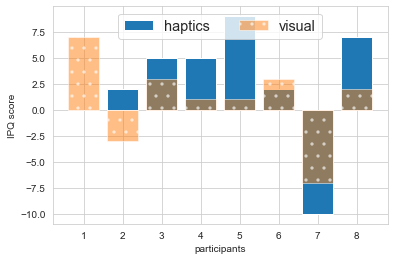

In [73]:

fig, ax = plt.subplots()

plt.bar(haptic_presence_data_frame['Id des Teilnehmers'], haptic_presence_data_frame['IPQ_score'])
plt.bar(visual_presence_data_frame['Id des Teilnehmers'],visual_presence_data_frame['IPQ_score'], hatch= '.', alpha=0.5)

ax.legend(["haptics" , "visual"] , ncol = 2, loc = "upper center", fontsize="x-large")

plt.xlabel('participants')
plt.ylabel('IPQ score')
plt.show()

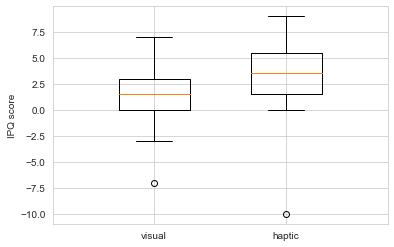

In [74]:
width = 0.35
# Creating plot
plt.boxplot(haptic_presence_data_frame.loc[:,'IPQ_score'], widths=width, labels=['haptic'])

plt.boxplot(visual_presence_data_frame.loc[:,'IPQ_score'], widths=width, positions=[width], labels=['visual'])

plt.ylabel('IPQ score')
# show plot
plt.show()  

In [75]:
ttest_rel(haptic_presence_data_frame['IPQ_score'], visual_presence_data_frame['IPQ_score'])

Ttest_relResult(statistic=0.9275578884164785, pvalue=0.3845038555471322)

In [76]:
bootstrap_t_test(haptic_presence_data_frame['IPQ_score'], visual_presence_data_frame['IPQ_score'])

The p-value is 0.725


# Witmer, Jerome, & Singer’s (2005) 29-item Presence Questionnaire (PQ Version 3)

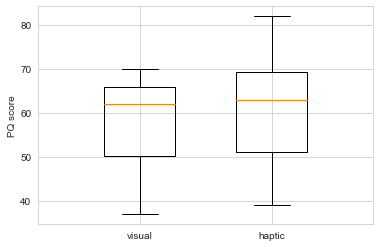

In [77]:
width = 0.35
# Creating plot
plt.boxplot(haptic_presence_data_frame.loc[:,'PQ_score'], widths=width, labels=['haptic'])

plt.boxplot(visual_presence_data_frame.loc[:,'PQ_score'], widths=width, positions=[width], labels=['visual'])

plt.ylabel('PQ score')
# show plot
plt.show()  

In [78]:
ttest_rel(haptic_presence_data_frame['PQ_score'], visual_presence_data_frame['PQ_score'])

Ttest_relResult(statistic=0.7469322898222291, pvalue=0.4794359271023806)

Ich konnte die Ereignisse gut kontrollieren.
PQ_INV1_enc
0   -1
1    2
2    3
3    2
4    2
5    3
6    2
7    4
Name: PQ_INV1_enc, dtype: int8
0    3
1    2
2    3
3    2
4    2
5    0
6    2
7    3
Name: PQ_INV1_enc, dtype: int8


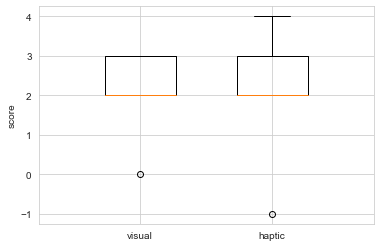

Ich habe die Interaktion mit der virtuellen Umgebung als natürlich empfunden.
PQ_INV3_enc
0    0
1    3
2    3
3    3
4    3
5    3
6    2
7    2
Name: PQ_INV3_enc, dtype: int8
0    3
1    3
2    3
3    0
4    2
5    0
6    2
7    2
Name: PQ_INV3_enc, dtype: int8


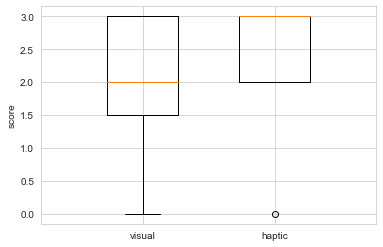

Die visuellen Aspekte haben mich stark eingezogen.
PQ_INV4_enc
0    3
1    4
2    3
3    3
4    3
5    3
6    0
7    4
Name: PQ_INV4_enc, dtype: int8
0    2
1    4
2    3
3    3
4    3
5    4
6    2
7    4
Name: PQ_INV4_enc, dtype: int8


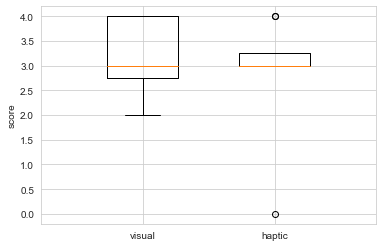

Ich finde das Kontrollieren der Bewegung natürlich.
PQ_INV5_enc
0    2
1    0
2    4
3    3
4    3
5    3
6    0
7    2
Name: PQ_INV5_enc, dtype: int8
0    3
1   -1
2    2
3    3
4    3
5    0
6    3
7    2
Name: PQ_INV5_enc, dtype: int8


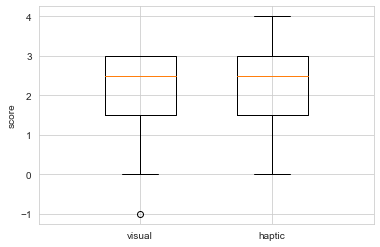

Ich finde die Bewegungen von Objekten im virtuellen Raum waren überzeugend.
PQ_INV6_enc
0    0
1    4
2    3
3    3
4    3
5    2
6    3
7    3
Name: PQ_INV6_enc, dtype: int8
0    2
1    3
2    3
3    3
4    3
5    3
6    3
7    4
Name: PQ_INV6_enc, dtype: int8


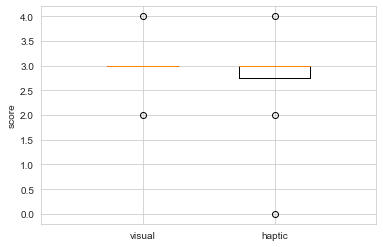

Ich konnten die Umgebung mit meinen Augen leicht durchsuchen.
PQ_INV8_enc
0    3
1    3
2    3
3    3
4    3
5    3
6    4
7    4
Name: PQ_INV8_enc, dtype: int8
0    4
1    3
2    3
3    3
4    3
5    2
6    4
7    4
Name: PQ_INV8_enc, dtype: int8


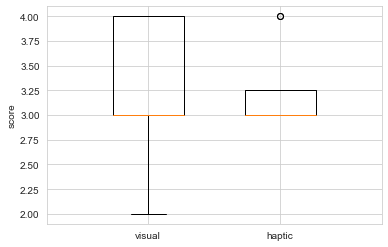

Ich empfand es natürlich sich durch die virtuelle Welt zu bewegen.
PQ_INV9_enc
0    2
1    3
2    3
3    3
4    3
5    2
6    4
7    3
Name: PQ_INV9_enc, dtype: int8
0    4
1    3
2    2
3    3
4    2
5    2
6    4
7    2
Name: PQ_INV9_enc, dtype: int8


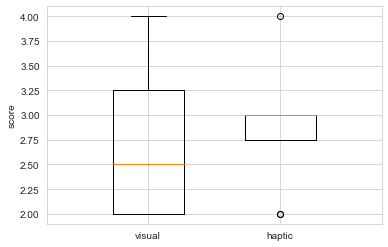

Ich konnte die Objekte in der virtuellen Umgebung gut bewegen bzw. manipulieren.
PQ_INV10_enc
0   -1
1    0
2    2
3    3
4    3
5    3
6    0
7    4
Name: PQ_INV10_enc, dtype: int8
0    2
1    0
2    2
3    3
4    3
5    0
6    2
7    2
Name: PQ_INV10_enc, dtype: int8


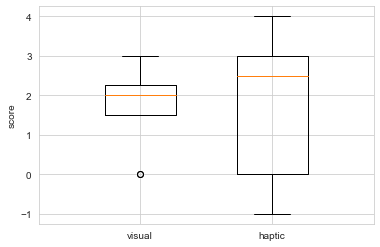

Ich war in dem virtuellen Erlebnis stark einbezogen.
PQ_INV11_enc
0    3
1    4
2    2
3    3
4    3
5    3
6    1
7    4
Name: PQ_INV11_enc, dtype: int8
0    4
1    4
2    2
3    3
4    3
5    3
6    1
7    3
Name: PQ_INV11_enc, dtype: int8


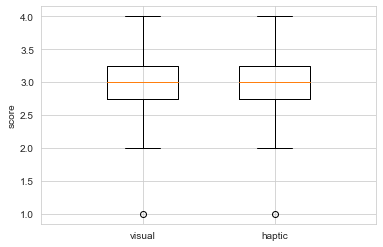

Ich finde es sehr einfach Objekte durch physische Interaktionen (z.B. Berührung) zu identifizieren.
PQ_INV12_enc
0    1
1   -1
2    3
3    3
4    3
5    2
6    2
7    3
Name: PQ_INV12_enc, dtype: int8
0    3
1   -2
2    3
3    2
4    3
5    0
6    3
7   -1
Name: PQ_INV12_enc, dtype: int8


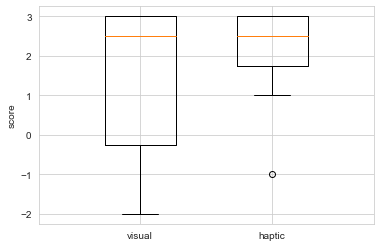

Das Audio hat mich stark eingezogen.
PQ_SEN1_enc
0    1
1    3
2    2
3    0
4    2
5    3
6   -2
7    3
Name: PQ_SEN1_enc, dtype: int8
0    1
1    2
2    1
3    2
4    2
5    3
6   -2
7    4
Name: PQ_SEN1_enc, dtype: int8


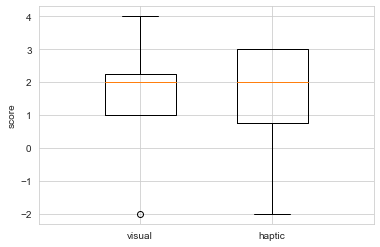

Ich konnte verschiedene Geräusche gut unterscheiden.
PQ_SEN2_enc
0    2
1   -1
2    2
3    2
4    3
5    3
6    2
7    4
Name: PQ_SEN2_enc, dtype: int8
0    3
1   -1
2    1
3    3
4    2
5    3
6   -1
7    4
Name: PQ_SEN2_enc, dtype: int8


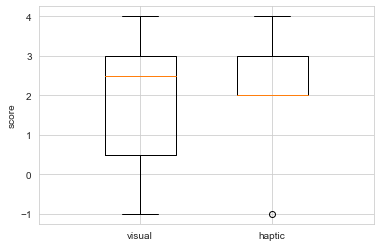

Ich konnte Geräusche gut lokalisieren.
PQ_SEN3_enc
0    2
1   -1
2    2
3    2
4    3
5    3
6    0
7    3
Name: PQ_SEN3_enc, dtype: int8
0    2
1   -2
2    1
3    3
4    2
5    3
6    0
7    4
Name: PQ_SEN3_enc, dtype: int8


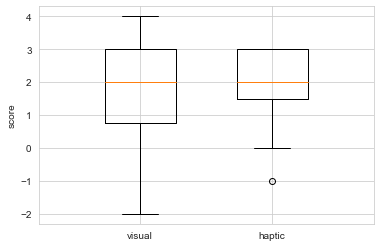

Ich konnte die Umgebung gut mit meiner Hand wahrnehmen.
PQ_SEN4_enc
0    3
1    3
2    2
3    3
4    3
5    3
6   -1
7    3
Name: PQ_SEN4_enc, dtype: int8
0    1
1   -1
2    1
3    2
4    3
5    0
6    2
7    0
Name: PQ_SEN4_enc, dtype: int8


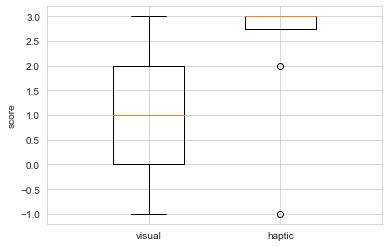

Ich konnte Objekte aus nächster Nähe beobachten.
PQ_SEN5_enc
0    3
1    3
2    2
3    3
4    3
5    2
6    3
7    4
Name: PQ_SEN5_enc, dtype: int8
0    4
1    3
2    3
3    3
4    3
5    1
6    3
7    4
Name: PQ_SEN5_enc, dtype: int8


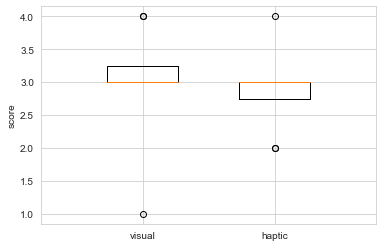

Ich konnte Objekte gut von verschiedenen Perspektiven anschauen.
PQ_SEN6_enc
0    3
1    4
2    2
3    3
4    4
5    2
6    4
7    2
Name: PQ_SEN6_enc, dtype: int8
0    4
1    4
2    3
3    3
4    4
5    1
6    4
7    3
Name: PQ_SEN6_enc, dtype: int8


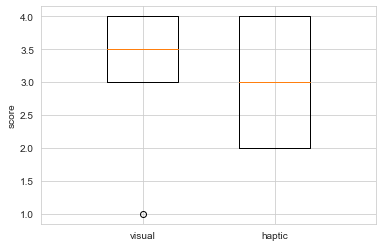

Ich konnte gut vorhersagen was die Reaktionen auf meine Aktionen sind.
PQ_IMM1_enc
0    1
1    0
2    2
3    3
4    4
5    2
6    3
7    4
Name: PQ_IMM1_enc, dtype: int8
0    2
1    2
2    3
3    3
4    2
5    1
6    3
7    2
Name: PQ_IMM1_enc, dtype: int8


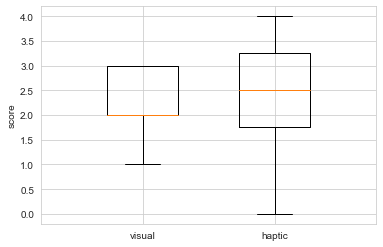

Ich konnte mich sehr schnell an die virtuelle Umgebung gewöhnen.
PQ_IMM2_enc
0    0
1    3
2    3
3    3
4    4
5    3
6    4
7    4
Name: PQ_IMM2_enc, dtype: int8
0    3
1    3
2    3
3    3
4    3
5    2
6    4
7    4
Name: PQ_IMM2_enc, dtype: int8


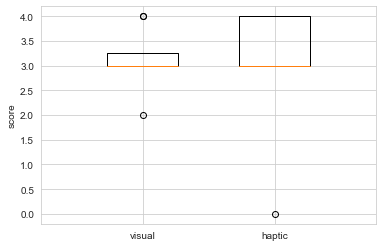

Zum Ende des Spiels hatte ich das Gefühl mit der virtuellen Umgebung kompetent interagieren zu können.
PQ_IMM3_enc
0    2
1    3
2    2
3    3
4    4
5    2
6    2
7    4
Name: PQ_IMM3_enc, dtype: int8
0    4
1    3
2    3
3    3
4    3
5    0
6    3
7    2
Name: PQ_IMM3_enc, dtype: int8


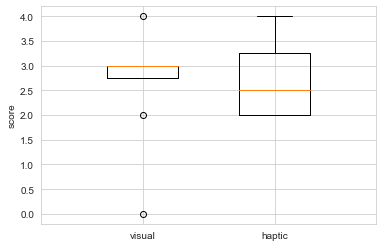

Ich konnte mich gut auf die Aufgaben das Spiel zu lösen konzentrieren ohne stark auf die Mechanismen um die Aufgaben zu lösen achten zu müssen.
PQ_IMM4_enc
0    2
1    4
2    3
3    3
4    4
5    3
6    0
7    4
Name: PQ_IMM4_enc, dtype: int8
0    4
1    4
2    3
3    3
4    4
5    2
6    4
7    2
Name: PQ_IMM4_enc, dtype: int8


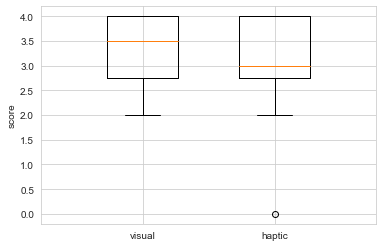

Meine Sinne waren Stark in das Spiel einbezogen.
PQ_IMM5_enc
0    4
1    2
2    3
3    3
4    3
5    3
6    2
7    4
Name: PQ_IMM5_enc, dtype: int8
0    4
1    2
2    3
3    3
4    2
5    3
6    2
7    3
Name: PQ_IMM5_enc, dtype: int8


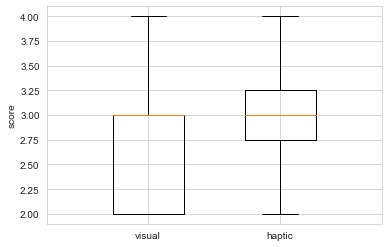

Es gab Momente in denen ich vollständig im Spiel eintauchen konnte.
PQ_IMM6_enc
0    4
1    3
2    2
3    3
4    3
5    3
6   -1
7    4
Name: PQ_IMM6_enc, dtype: int8
0    4
1    3
2    3
3    3
4    2
5    3
6   -1
7    3
Name: PQ_IMM6_enc, dtype: int8


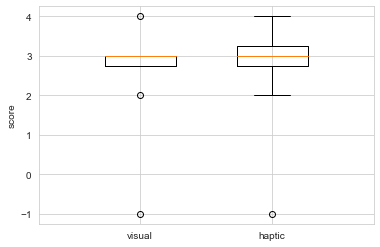

Ich konnte mich leicht an die Geräte involviert im Spiel gewöhnen.
PQ_IMM7_enc
0    4
1    3
2    3
3    3
4    4
5    3
6    3
7    4
Name: PQ_IMM7_enc, dtype: int8
0    3
1    3
2    3
3    3
4    3
5    0
6    4
7    3
Name: PQ_IMM7_enc, dtype: int8


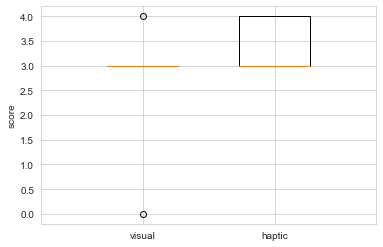

Für mich waren die Informationen die meine verschiedenen Sinne wahrgenommen haben konsistent.
PQ_IMM8_enc
0    3
1    1
2    3
3    3
4    3
5    2
6    2
7    3
Name: PQ_IMM8_enc, dtype: int8
0    2
1    1
2    2
3    3
4    3
5    2
6    1
7    0
Name: PQ_IMM8_enc, dtype: int8


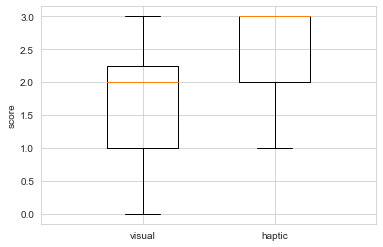

Die Verzögerung zwischen meinen Aktionen und erwarteten Ergebnis waren angemessen.
PQ_INT1_enc
0    1
1    3
2    2
3    3
4    2
5    2
6    2
7    3
Name: PQ_INT1_enc, dtype: int8
0    2
1    4
2    1
3    3
4    3
5    1
6    3
7    1
Name: PQ_INT1_enc, dtype: int8


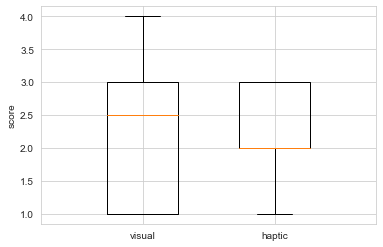

Die Qualität der optischen Anzeige hat mich daran gehindert im Spiel einzutauchen.
PQ_INT2_enc
0    2
1   -2
2    1
3   -1
4    0
5   -2
6   -2
7   -2
Name: PQ_INT2_enc, dtype: int8
0   -1
1   -2
2    2
3   -1
4    0
5   -1
6   -1
7   -1
Name: PQ_INT2_enc, dtype: int8


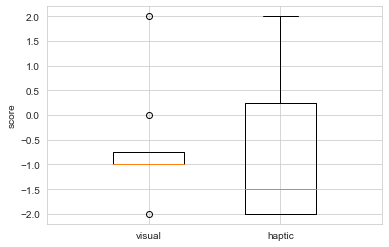

Die Geräte die ich benutzt habe, haben mich abgelenkt.
PQ_INT3_enc
0    2
1   -2
2   -1
3   -1
4   -2
5   -2
6    0
7   -2
Name: PQ_INT3_enc, dtype: int8
0   -2
1   -2
2    1
3   -1
4   -2
5   -1
6   -2
7   -2
Name: PQ_INT3_enc, dtype: int8


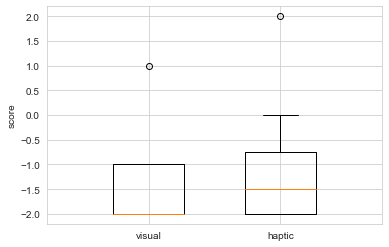

In [79]:
for index, column in enumerate(pq_encoded):
    print(pq_questions[index])
    print(column)
    print(haptic_presence_data_frame[column])
    print(visual_presence_data_frame[column])
    width = 0.35
    # Creating plot
    plt.boxplot(haptic_presence_data_frame[column], widths=width, labels=['haptic'])

    plt.boxplot(visual_presence_data_frame[column], widths=width, positions=[width], labels=['visual'])

    plt.ylabel('score')
    # show plot
    plt.show()  

In [80]:
wilcoxon(haptic_presence_data_frame['PQ_IMM8_enc'], visual_presence_data_frame['PQ_IMM8_enc'])

C:\Users\Malte\anaconda3\envs\game-study\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Malte\anaconda3\envs\game-study\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=0.0, pvalue=0.05878172135535886)

In [81]:
print(haptic_presence_data_frame)
#haptic_presence_data_frame = haptic_presence_data_frame.drop(6,axis="index") 
#haptic_presence_data_frame = haptic_presence_data_frame.drop(2,axis="index") 


#visual_presence_data_frame = visual_presence_data_frame.drop(6,axis="index") 
#visual_presence_data_frame = visual_presence_data_frame.drop(2,axis="index") 
print(visual_presence_data_frame['PQ_SEN4_enc'])
print(haptic_presence_data_frame['PQ_SEN4_enc'])
wilcoxon(haptic_presence_data_frame['PQ_SEN4_enc'], visual_presence_data_frame['PQ_SEN4_enc'])

   ID       Start time  Completion time      Email  Name  Id des Teilnehmers  \
0   1   8/3/21 0:44:17   8/3/21 1:15:07  anonymous   NaN                   1   
1   4   8/3/21 6:36:59   8/3/21 6:46:36  anonymous   NaN                   2   
2   5   8/3/21 6:48:21   8/3/21 7:15:04  anonymous   NaN                   3   
3   8   8/3/21 9:23:19   8/3/21 9:34:09  anonymous   NaN                   4   
4   9  8/3/21 10:14:36  8/3/21 10:54:38  anonymous   NaN                   5   
5  12  8/3/21 11:33:02  8/3/21 11:43:42  anonymous   NaN                   6   
6  13   8/4/21 9:55:13  8/4/21 10:38:32  anonymous   NaN                   7   
7  16  8/4/21 22:47:48  8/4/21 23:03:42  anonymous   NaN                   8   

  Spieltyp auf den sich dieser Fragebogen bezieht.     Dauer  \
0                                       Mit Haptik   4:43.96   
1                                       Mit Haptik   1:04.34   
2                                       Mit Haptik   1:02.34   
3                      

C:\Users\Malte\anaconda3\envs\game-study\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\Malte\anaconda3\envs\game-study\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=5.0, pvalue=0.1247727360437228)

In [82]:
wilcoxon(haptic_presence_data_frame['PQ_INV3_enc'], visual_presence_data_frame['PQ_INV3_enc'])

WilcoxonResult(statistic=3.0, pvalue=0.4496917979688909)